# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier



# Load Dataset

In [2]:
df = pd.read_csv('smart_home_dataset.csv')
df.head()

,Unix Timestamp,Transaction_ID,Television,Dryer,Oven,Refrigerator,Microwave,Line Voltage,Voltage,Apparent Power,Energy Consumption (kWh),Month,Day of the Week,Hour of the Day,Offloading Decision
0,1577836800,1,0,0,0,1,0,237,233,1559,24.001763,January,Wednesday,0,Local
1,1577839322,2,0,1,0,0,1,232,230,1970,31.225154,January,Wednesday,0,Remote
2,1577841845,3,0,1,0,0,0,223,222,1684,70.460700,January,Wednesday,1,Remote
3,1577844368,4,1,0,1,1,0,225,224,1694,32.264043,January,Wednesday,2,Remote
4,1577846891,5,1,0,0,1,0,222,214,1889,32.728111,January,Wednesday,2,Local


# Preprocessing Categorical Features

In [3]:
print(df.isna().sum())

le_month = LabelEncoder()
le_day = LabelEncoder()
df['Month_encoded'] = le_month.fit_transform(df['Month'])
df['Day_encoded'] = le_day.fit_transform(df['Day of the Week'])
# Label encoding
le_day = LabelEncoder()
df['Day_encoded'] = le_day.fit_transform(df['Day of the Week'])

# Map and encode month
month_map = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5,
             'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,
             'November': 11, 'December': 12}
df['Month_num'] = df['Month'].map(month_map)

# Cyclical encoding for hour and month
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour of the Day'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour of the Day'] / 24)
df['Month_sin'] = np.sin(2 * np.pi * df['Month_num'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month_num'] / 12)

# Offloading binary
df['Offloading_Binary'] = df['Offloading Decision'].map({'Local': 0, 'Remote': 1})

# Aggregates and interactions
df['Total_Appliances_On'] = df[['Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave']].sum(axis=1)
df['Power_per_Appliance'] = df['Apparent Power'] / (df['Total_Appliances_On'] + 1)
df['Voltage_Drop'] = df['Line Voltage'] - df['Voltage']
df['Appliances_x_Hour'] = df['Total_Appliances_On'] * df['Hour of the Day']
df['Power_x_Offloading'] = df['Apparent Power'] * df['Offloading_Binary']

# Lag features (time-aware)
df['Lag_1_Consumption'] = df['Energy Consumption (kWh)'].shift(1)
df['Lag_2_Consumption'] = df['Energy Consumption (kWh)'].shift(2)

# Create bins for Low, Medium, High consumption
df['Energy_Level'] = pd.qcut(df['Energy Consumption (kWh)'], q=3, labels=['Low', 'Medium', 'High'])

le_enerygy = LabelEncoder()
df['Energy_Level'] = le_enerygy.fit_transform(df['Energy_Level'])
# Drop NA from lag features
df.dropna(inplace=True)


Unix Timestamp              0
Transaction_ID              0
Television                  0
Dryer                       0
Oven                        0
Refrigerator                0
Microwave                   0
Line Voltage                0
Voltage                     0
Apparent Power              0
Energy Consumption (kWh)    0
Month                       0
Day of the Week             0
Hour of the Day             0
Offloading Decision         0
dtype: int64


# Feature Selection

In [4]:

# Final feature set
features = [
    'Television', 'Dryer', 'Oven', 'Refrigerator', 'Microwave',
    'Line Voltage', 'Voltage', 'Voltage_Drop', 'Apparent Power',
    'Total_Appliances_On', 'Power_per_Appliance',
    'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos',
    'Day_encoded', 'Offloading_Binary',
    'Lag_1_Consumption', 'Lag_2_Consumption',
    'Appliances_x_Hour', 'Power_x_Offloading','Energy Consumption (kWh)'
]
target = 'Energy_Level'

X = df[features]
y = df[target]

# Exploratory Data Analysis

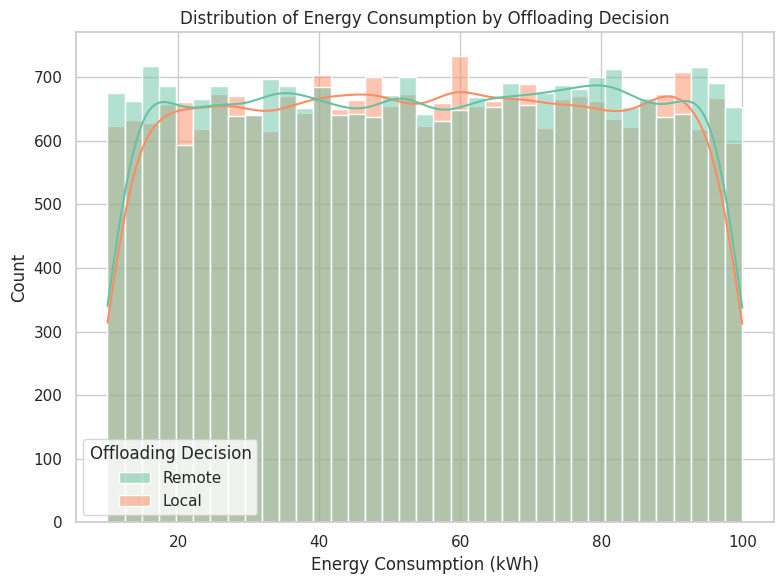

In [5]:
sns.set(style="whitegrid")

# 1. Distribution of Energy Consumption
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Energy Consumption (kWh)', hue='Offloading Decision', kde=True, palette='Set2')
plt.title('Distribution of Energy Consumption by Offloading Decision')
plt.tight_layout()
plt.show()

/tmp/ipython-input-2168162722.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Offloading Decision', y='Line Voltage', palette='pastel')


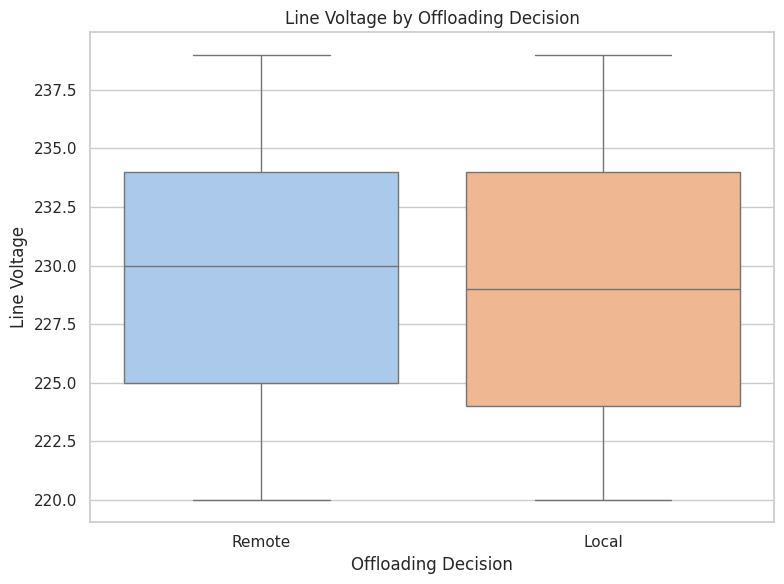

In [6]:
# 2. Line Voltage by Offloading Decision
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Offloading Decision', y='Line Voltage', palette='pastel')
plt.title('Line Voltage by Offloading Decision')
plt.tight_layout()
plt.show()

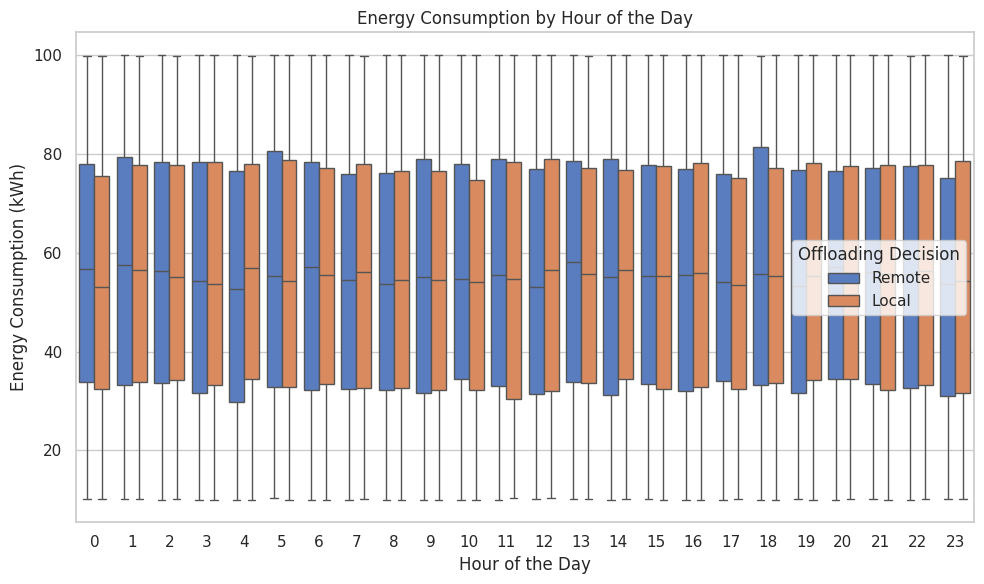

In [ ]:
# 3. Hourly Energy Consumption
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Hour of the Day', y='Energy Consumption (kWh)', hue='Offloading Decision', palette='muted')
plt.title('Energy Consumption by Hour of the Day')
plt.tight_layout()
plt.show()

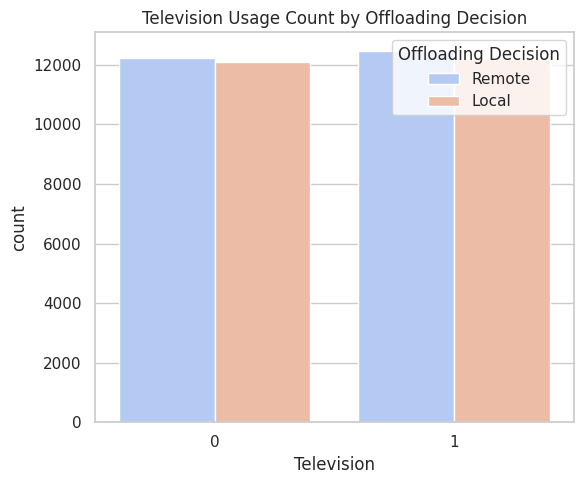

In [ ]:
# 4. Television Usage Count
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x='Television', hue='Offloading Decision', palette='coolwarm')
plt.title('Television Usage Count by Offloading Decision')
plt.tight_layout()
plt.show()

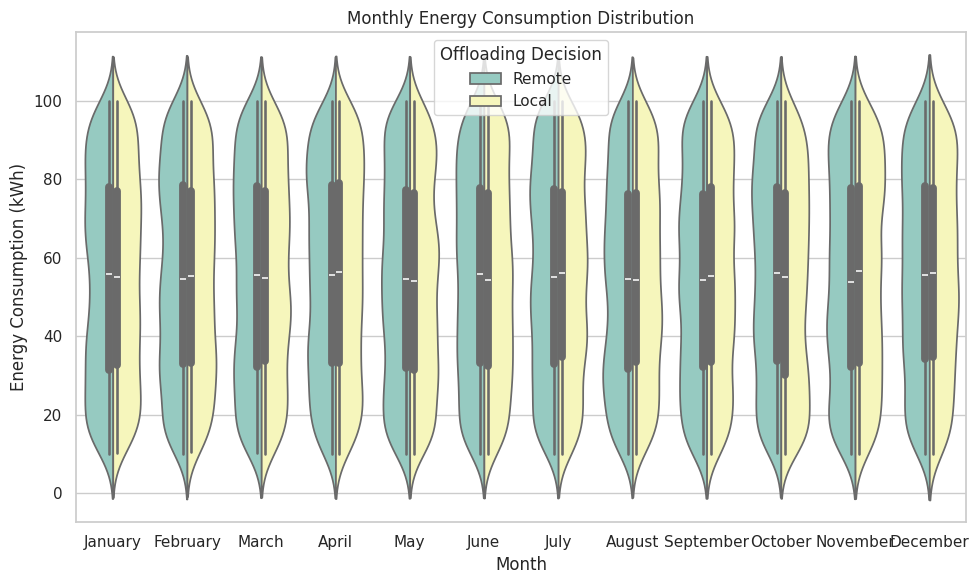

In [ ]:
# 5. Monthly Energy Distribution
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Month', y='Energy Consumption (kWh)', hue='Offloading Decision', split=True, palette='Set3')
plt.title('Monthly Energy Consumption Distribution')
plt.tight_layout()
plt.show()

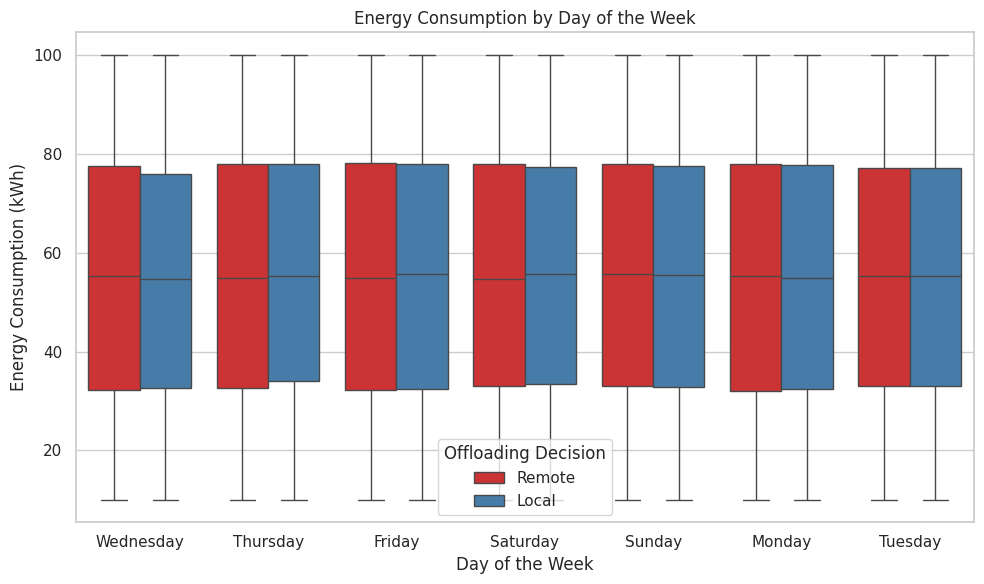

In [ ]:
# 6. Weekly Energy Consumption
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Day of the Week', y='Energy Consumption (kWh)', hue='Offloading Decision', palette='Set1')
plt.title('Energy Consumption by Day of the Week')
plt.tight_layout()
plt.show()

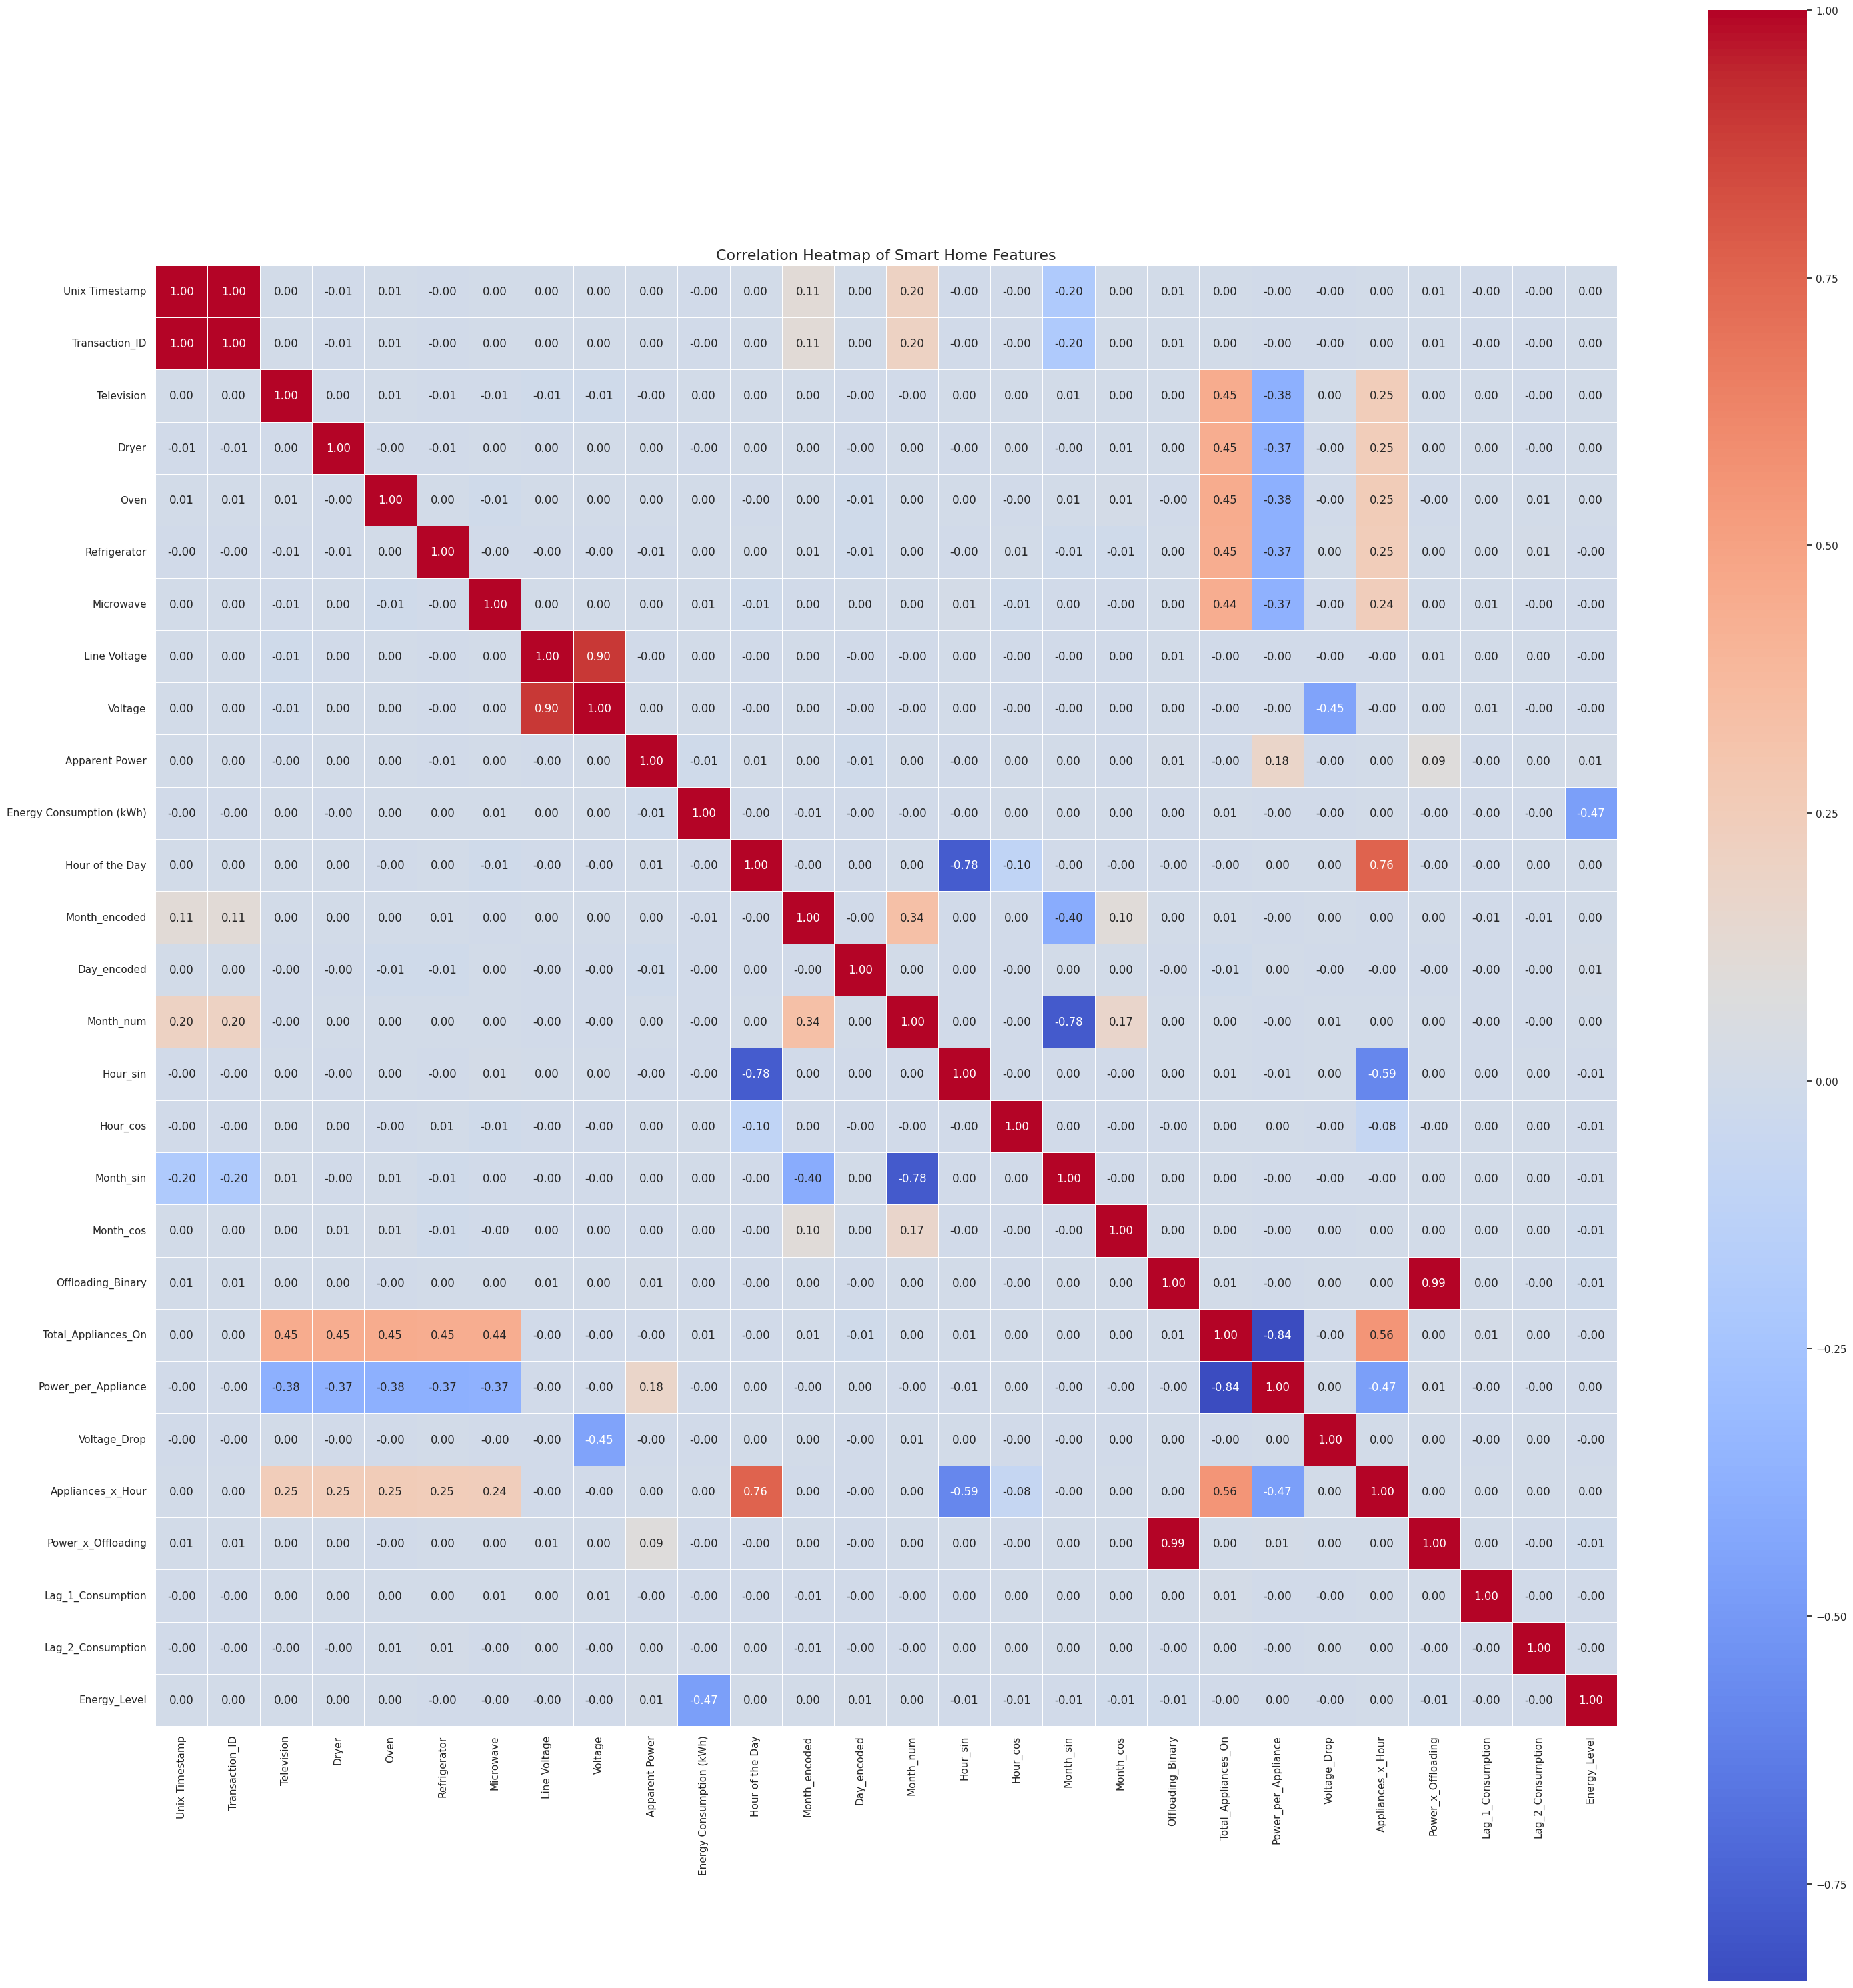

In [ ]:
# 7 Compute the correlation matrix
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Smart Home Features', fontsize=16)
plt.tight_layout()
# plt.savefig("correlation_heatmap.png")
plt.show()

# Train-Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model Building

In [8]:




# Classification models
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score': f1_score(y_test, y_pred, average='weighted')
    }

# Create DataFrame of results
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})
print("Classification Model Performance:")
print(results_df.sort_values(by='F1 Score', ascending=False))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:41:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Model Performance:
                 Model  Accuracy  Precision    Recall  F1 Score
1        Random Forest  1.000000   1.000000  1.000000  1.000000
2        Decision Tree  1.000000   1.000000  1.000000  1.000000
5    Gradient Boosting  1.000000   1.000000  1.000000  1.000000
6              XGBoost  0.997039   0.997039  0.997039  0.997038
3                  SVM  0.988871   0.988881  0.988871  0.988875
0  Logistic Regression  0.974372   0.974391  0.974372  0.974381
4                  KNN  0.885134   0.884779  0.885134  0.884934


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:44:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


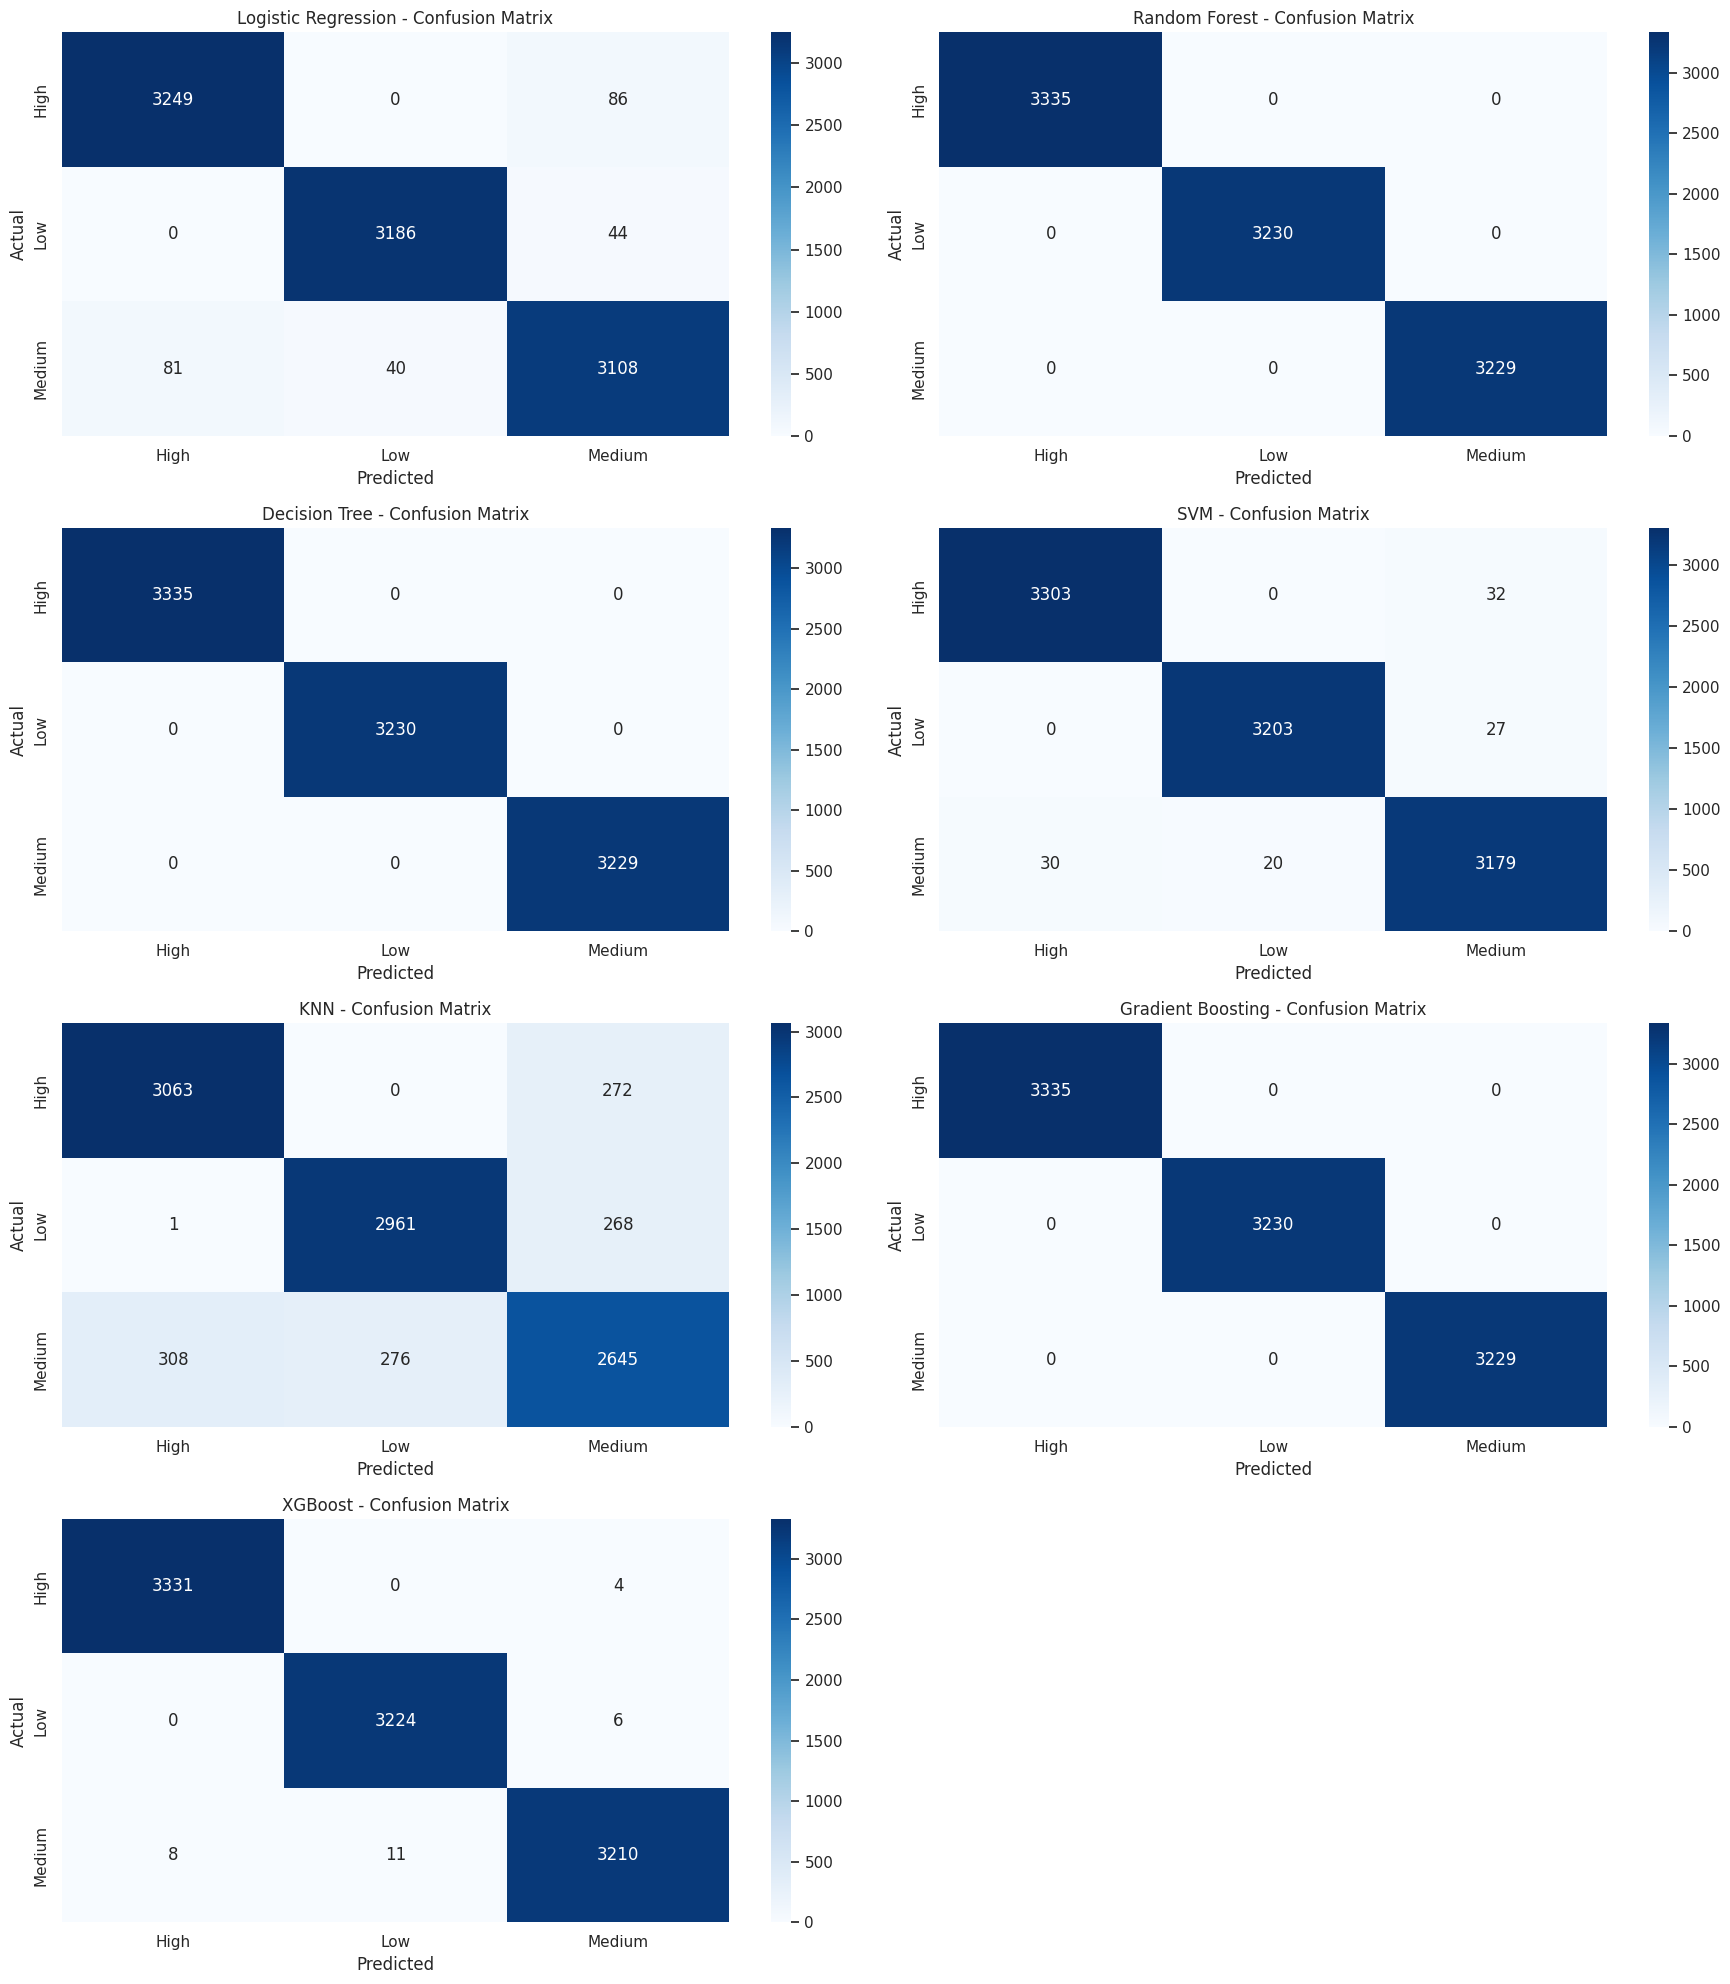

In [9]:


# Reuse classifiers from earlier
metrics_table = []

# Set figure size for confusion matrices
plt.figure(figsize=(18, 20))
plot_idx = 1

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test) if hasattr(clf, "predict_proba") else None

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    loss = log_loss(y_test, y_proba) if y_proba is not None else np.nan

    metrics_table.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'Log Loss': loss
    })

    # Plot confusion matrix
    plt.subplot(4, 2, plot_idx)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_enerygy.classes_, yticklabels=le_enerygy.classes_)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plot_idx += 1

plt.tight_layout()
plt.show()





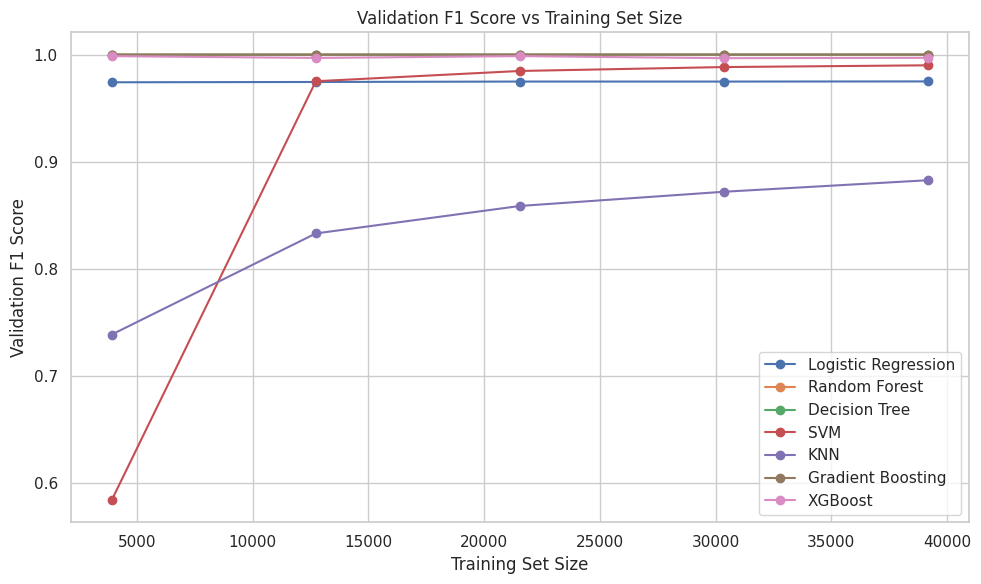

In [ ]:

# Dictionary to hold model learning curve scores
learning_curve_results = {}

plt.figure(figsize=(10, 6))

for name, clf in classifiers.items():
    train_sizes, train_scores, val_scores = learning_curve(
        clf, X, y, cv=5, scoring='f1_weighted', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1)

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    learning_curve_results[name] = {
        'train_sizes': train_sizes,
        'train_scores': train_mean,
        'val_scores': val_mean
    }

    # Plotting validation F1 score for each model
    plt.plot(train_sizes, val_mean, marker='o', label=name)

plt.title('Validation F1 Score vs Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('Validation F1 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Models with predict_proba: ['Logistic Regression', 'Random Forest', 'Decision Tree', 'SVM', 'KNN', 'Gradient Boosting', 'XGBoost']


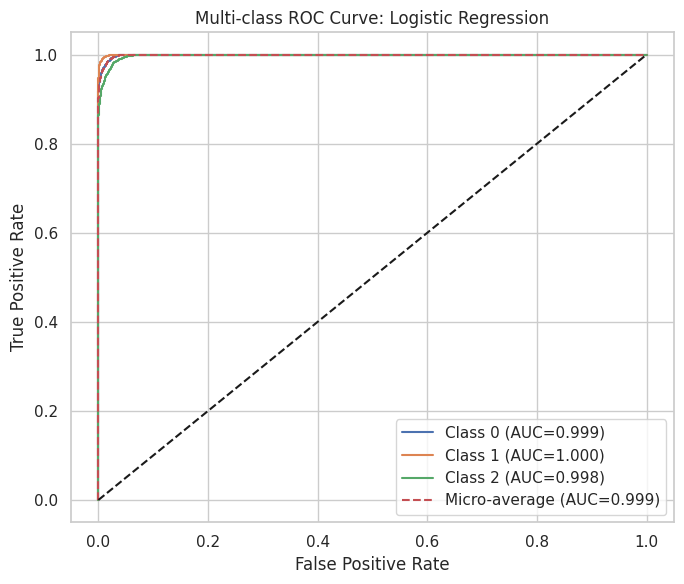

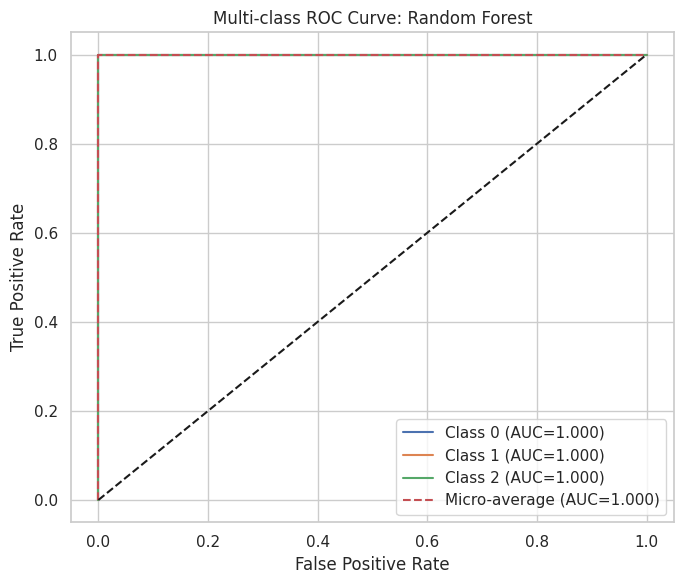

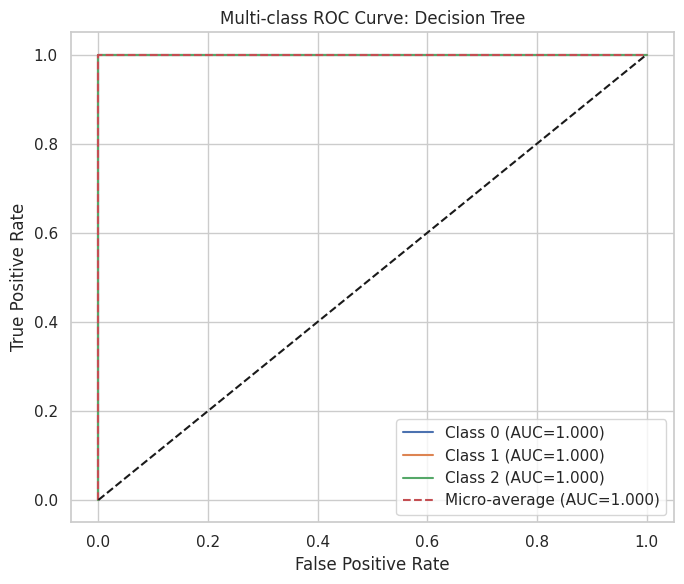

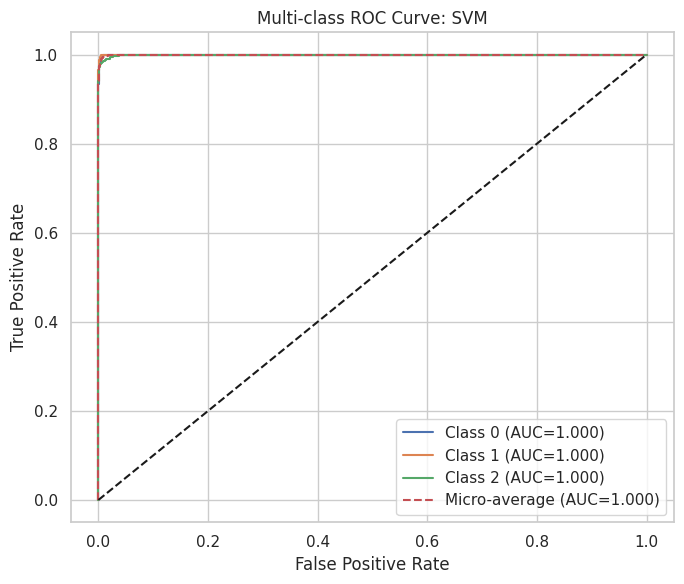

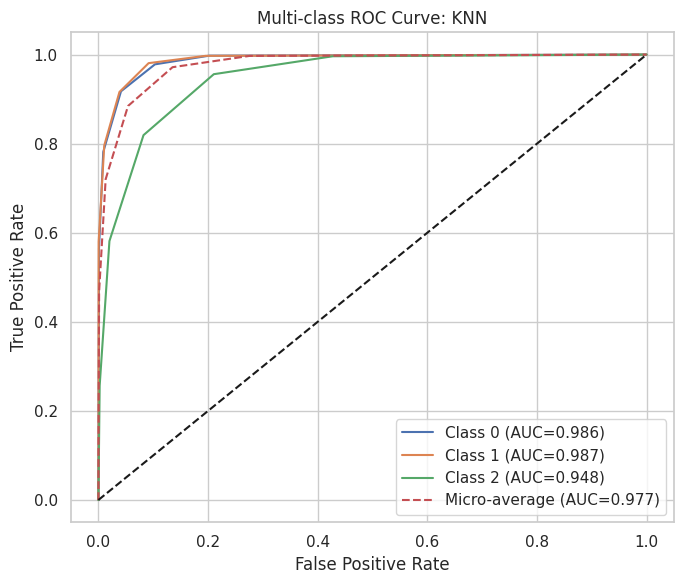

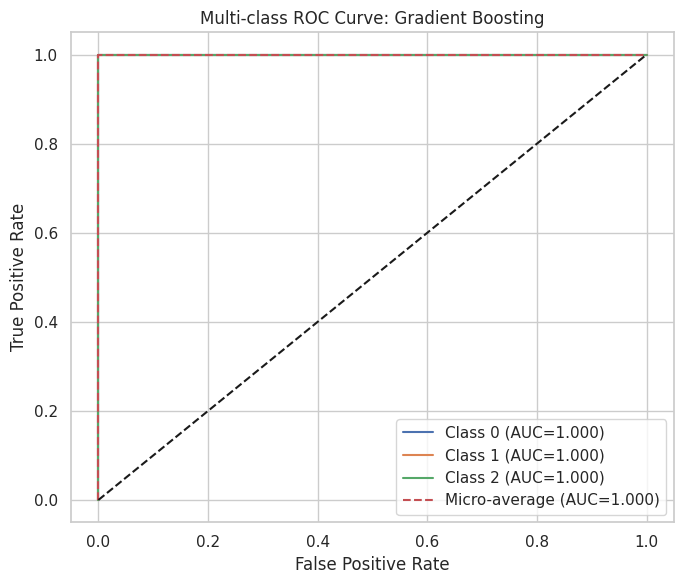

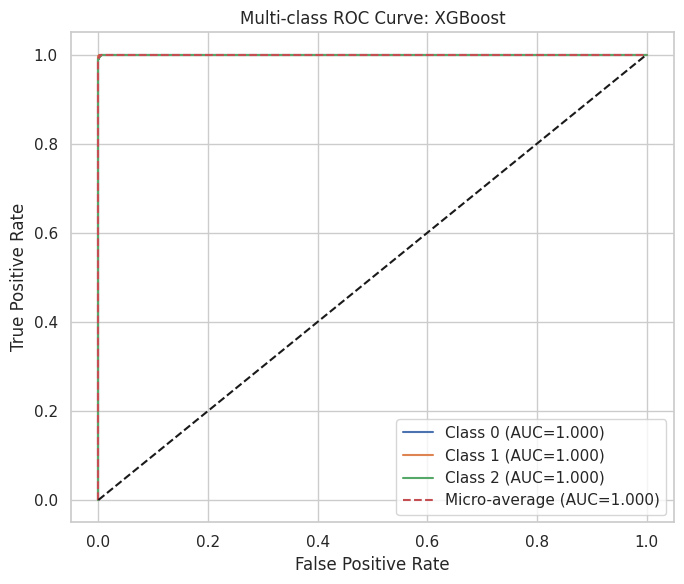


AUC Summary (macro, micro, per-class):
                     macro  micro      0      1      2
Logistic Regression  0.999  0.999  0.999  1.000  0.998
Random Forest        1.000  1.000  1.000  1.000  1.000
Decision Tree        1.000  1.000  1.000  1.000  1.000
SVM                  1.000  1.000  1.000  1.000  1.000
KNN                  0.974  0.977  0.986  0.987  0.948
Gradient Boosting    1.000  1.000  1.000  1.000  1.000
XGBoost              1.000  1.000  1.000  1.000  1.000

AUC Summary with class names:
                     macro  micro  Class High  Class Low  Class Medium
Logistic Regression  0.999  0.999       0.999      1.000         0.998
Random Forest        1.000  1.000       1.000      1.000         1.000
Decision Tree        1.000  1.000       1.000      1.000         1.000
SVM                  1.000  1.000       1.000      1.000         1.000
KNN                  0.974  0.977       0.986      0.987         0.948
Gradient Boosting    1.000  1.000       1.000      1.000       

In [11]:
# ==== Multi-class ROC & AUC (macro/micro + per-class) ====

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Make sure SVM exposes predict_proba
if 'SVM' in classifiers:
    # Re-define with probability=True (safe even if already defined)
    from sklearn.svm import SVC
    classifiers['SVM'] = SVC(probability=True, random_state=42)

# 2) (Re)fit ONLY models that aren't already fitted (cheap to refit anyway)
for name, clf in classifiers.items():
    try:
        # If estimator isn't fitted, this will raise
        getattr(clf, "classes_")
    except Exception:
        clf.fit(X_train, y_train)

# 3) Build models_dict from those that support predict_proba
models_dict = {name: clf for name, clf in classifiers.items() if hasattr(clf, "predict_proba")}
print("Models with predict_proba:", list(models_dict.keys()))

# 4) Prepare binarized labels (ensure stable, sorted class order)
classes = np.sort(np.unique(y_test))
y_test_bin = label_binarize(np.asarray(y_test), classes=classes)

def plot_multi_class_roc(model, X_te, y_bin, label, classes):
    """Plot per-class ROC + micro-average; return dict of AUCs."""
    y_score = model.predict_proba(X_te)
    fpr, tpr, roc_auc = {}, {}, {}

    # Per-class ROC/AUC
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average ROC/AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-average ROC/AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    # Plot
    plt.figure(figsize=(7, 6))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC={roc_auc[i]:.3f})')
    plt.plot(fpr["micro"], tpr["micro"], linestyle='--',
             label=f'Micro-average (AUC={roc_auc["micro"]:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Multi-class ROC Curve: {label}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return roc_auc

# 5) Run for selected/top models (use all with predict_proba by default)
auc_results = {}
for name, model in models_dict.items():
    auc_results[name] = plot_multi_class_roc(model, X_test, y_test_bin, name, classes)

# 6) Summary table: macro/micro first, then per-class AUCs
auc_df = pd.DataFrame(auc_results).T
per_class_cols = list(range(len(classes)))  # 0..K-1 per-class
auc_df = auc_df[['macro', 'micro'] + per_class_cols].round(3)

print("\nAUC Summary (macro, micro, per-class):")
print(auc_df)

# Optional: map class indices back to original label names (if you want)
try:
    class_names = [le_enerygy.inverse_transform([c])[0] for c in classes]
    renamed_cols = ['macro', 'micro'] + [f'Class {cn}' for cn in class_names]
    auc_df.columns = renamed_cols
    print("\nAUC Summary with class names:")
    print(auc_df)
except Exception:
    pass

print(auc_df.round(3))
